In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import sys

In [2]:
# custom parser because we can't read the last column into one cell (34359453)
# returns data frame with every change record
def parse(fname, NROWS=10000, NSKIP=1):
    NAMES=['index', 'type', 'time', 'date', 'flag', 'msg']
    records = []
    with open(fname, 'r') as f:
        i = 0
        for line in f:
            i += 1
            if i < NSKIP + 1: continue
            if i > NROWS + 1: break
        
            r = []; msg = ""
            for word in line.split(' '):
                if len(r) < len(NAMES) - 1 :
                    r.append(word)        # structured change log line
                else:
                    if word != '\n':
                        msg += word + ' ' # message isn't delimited
            r.append(msg)
            records.append(r)
    print "done w/ "  + fname
    return pd.DataFrame(records, columns=NAMES)
#df = parse("/root/l1-mar29-changelog-anon.log", NROWS=1000000)
df0 = parse("/root/day0", NROWS=36884)
df1 = parse("/root/day1", NROWS=1000000) #13249412)
df2 = parse("/root/day2", NROWS=1000000) #21073163)

done w/ /root/day0
done w/ /root/day1
done w/ /root/day2


In [3]:
def assign_unique_keys(keys):
    accesses = []; nkeys = 0
    for key in keys:
        try:
            keyid = keyids[key]
        except:
            keyids[key] = nkeys
            keyid = nkeys
            nkeys += 1
        accesses.append(keyid)
    return accesses

def to_seconds(ts):
    hours, minutes, seconds = ts.split(':')
    return float(seconds) + 60*float(minutes) + 60*60*float(hours)  

def get_ops(df, op):
    ops = df[df['type'] == op]
    time = ops['time'].apply(lambda x: to_seconds(x)).as_matrix()
    keys = ops['msg'].apply(lambda x: x.split(' ')[0].split('=')[1][:-1][1:])
    if len(time) == 0:
        return [], []
    return time - time[0], assign_unique_keys(keys)

op=01CREAT len(keys)=9446
op=14SATTR len(keys)=15767
op=19ATIME len(keys)=0
op=01CREAT len(keys)=35503
op=14SATTR len(keys)=95679
op=19ATIME len(keys)=23210
op=01CREAT len(keys)=36407
op=14SATTR len(keys)=131315
op=19ATIME len(keys)=14393


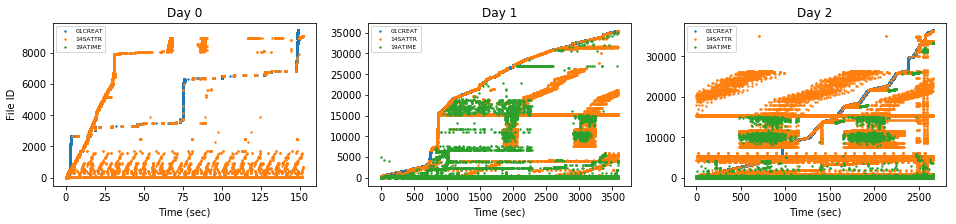

In [111]:
def plot_days(ops):
    fig, ax = plt.subplots(1, 3, figsize=(16, 3))
    dfs = [df0, df1, df2]
    for i in range(0, len(dfs)):
        for op in ops:
            time, keys = get_ops(dfs[i], op)
            ax[i].scatter(time, keys, s=2, label=op)
            print "op=" + op + " len(keys)=" + str(len(keys))
        ax[i].set_xlabel("Time (sec)")
        #ax[i].set_ylim(0, 35000)    
        ax[i].set_title("Day " + str(i))
        ax[i].legend(loc='upper left', fontsize=6)
    ax[0].set_ylabel("File ID")    

keyids = {}; plot_days(['01CREAT', '14SATTR', '19ATIME'])

op=19ATIME len(keys)=0
op=14SATTR len(keys)=15767
op=01CREAT len(keys)=9446
op=19ATIME len(keys)=23210
op=14SATTR len(keys)=95679
op=01CREAT len(keys)=35503
op=19ATIME len(keys)=14393
op=14SATTR len(keys)=131315
op=01CREAT len(keys)=36407
op=19ATIME len(keys)=0
op=19ATIME len(keys)=23210
op=19ATIME len(keys)=14393


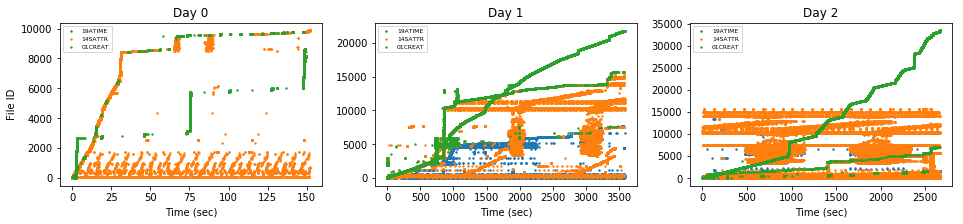

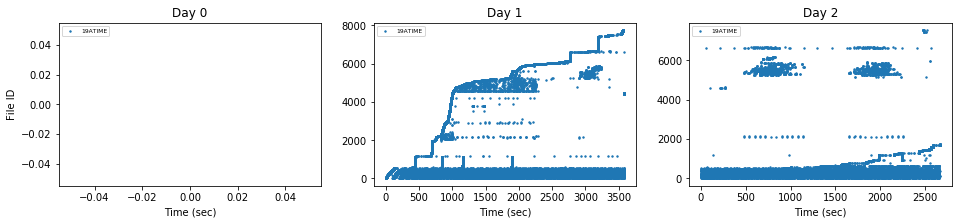

In [112]:
keyids = {}; plot_days(['19ATIME', '14SATTR',  '01CREAT'])
keyids = {}; plot_days(['19ATIME'])

## deceiving data visualization
Creating the index matters and shows different locality. We need to know the spatial locality of these namespace requests.

op=msg len(keys)=23210
6590


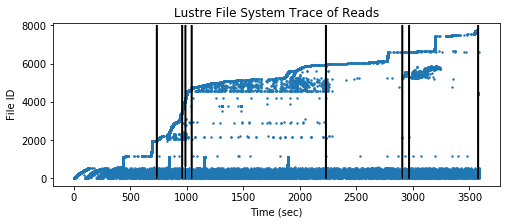

In [207]:
def find_regimes(time, keys):    
    fans = []                             # 1st pass: detect all possible fans
    fan  = {'start':  None,
            'end': float(time[-1]),
            'top': None,
            'bottom': 6590}
    print fan['bottom']
    for i in range(len(time)-1, -1, -1):  # iterate backwards!
        TS = float(time[i])
        ID = float(keys[i])
        if ID < 2000:
            continue
        if ID < fan['bottom']:            # we have found a new fan!
            #print "found new fan"
            fan['start'] = TS             # complete the fan
            fans.append(fan)              # save the fan and reset
            fan = {'start': None, 'end': TS, 'top': 0, 'bottom': ID}
        if ID > fan['top']:
            fan['top'] = ID
    fan['start'] = 0
    fans.append(fan)
    fans.reverse()   
    return fans
    #regimes = []                         # 2nd pass: avoid false positives; check fan height
    #for i in range(0, len(fans)-1):
    #    if fans[i]['top'] < fans[i+1]['bottom']: 
    #        fans[i]['end'] = fans[i+1]['end']
    #        regimes.append(fans[i])
    #regimes.append(fans[i])
    #return regimes

def plot_regimes(ax, regimes, window=5):
    props = dict(facecolor='black', width=1, headwidth=0)    
    #ax.scatter(df['shift'].astype(int), df['id'].astype(int), s=0.1, color='#998ec3') # plot the keyspace (purple dots)
    
    last_fan = regimes[0]                        # plot the fans
    for fan in regimes:
        if fan['start'] - last_fan['start'] > window:
            ax.annotate("",  arrowprops=props, ha="center", 
                        xy=(fan['start'], 0),#fan['top']),
                        xytext=(fan['start'], 8000))#fan['top']+1000))    
        last_fan = fan

keyids = {}
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
time, keys = get_ops(df1, '19ATIME')
ax.scatter(time, keys, s=2, label='19ATIME')
print "op=" + op + " len(keys)=" + str(len(keys))
ax.set_xlabel("Time (sec)")
ax.set_title("Lustre File System Trace of Reads")
ax.set_ylabel("File ID")
#ax.set_ylim(1000, 8000)

time, keys = get_ops(df1, '19ATIME')
regimes = find_regimes(time, keys)
plot_regimes(ax, regimes)